# Ultrametric benchmark for continual learning - Artificial sequence - Data analysis
#### Simon Lebastard - 01/11/2020

First off let's go to the directory where the latest data was stored for artificial_8:

In [1]:
import os

#cwd = os.getcwd()
cwd = '/home/proprietaire/Documents/Workspace/Jobs/Columbia/ultrametric_benchmark/Ultrametric-benchmark'

In [8]:
dataset = 'artificial_8'
nnarchi = 'CNN'
seq_length = 100000
n_batch = 10
sequence_generation_type = 'temporal_correlation'
linear_ratio_for_artificial_seq = 5
artificial_seq_len = 200

In this notebook, we'll loop through the files produced by the ultrametric framework accross temperatures and shuffle block size, and construct dictionnaries indexed by [T, blocksz].
We will then use those dicts to create the plots for DARPA.

In [9]:
dataroot = cwd + "/Results/" + dataset + '/' + nnarchi + '/' + sequence_generation_type + '_length' + str(seq_length) + '_batches' + str(n_batch) + '_seqlen' + str(artificial_seq_len) + '_ratio' + str(linear_ratio_for_artificial_seq)
os.chdir(dataroot)
os.listdir()

['T0.150_Memory0_block100_200113_21261578947211',
 'T0.150_Memory0_block1000_200113_21531578948799',
 'T0.400_Memory0_block1000_200113_22011578949298',
 'T0.150_Memory0_block10_200113_20591578945581',
 'T0.400_Memory0_block100_200113_21361578947778',
 'T0.650_Memory0_block10_200113_21171578946647',
 'T0.650_Memory0_block100_200113_21451578948317',
 'T0.400_Memory0_block10_200113_21071578946032',
 'T0.650_Memory0_block1000_200113_22101578949858']

In [19]:
# artificial_8 datapaths
datapaths = {
    'artificial8_ratio5_temporal_correlation': {
        (0.15, 100): 'T0.150_Memory0_block100_200113_21261578947211',
        (0.15, 1000): 'T0.150_Memory0_block1000_200113_21531578948799',
        (0.40, 1000): 'T0.400_Memory0_block1000_200113_22011578949298',
        (0.15, 10): 'T0.150_Memory0_block10_200113_20591578945581',
        (0.40, 100): 'T0.400_Memory0_block100_200113_21361578947778',
        (0.65, 10): 'T0.650_Memory0_block10_200113_21171578946647',
        (0.65, 100): 'T0.650_Memory0_block100_200113_21451578948317',
        (0.40, 10): 'T0.400_Memory0_block10_200113_21071578946032',
        (0.65, 1000): 'T0.650_Memory0_block1000_200113_22101578949858'
    },
    'artificial16_ratio1_temporal_correlation': {
        (0.15, 10): 'T0.150_Memory0_block10_200112_22211578864068',
        (0.15, 100): 'T0.150_Memory0_block100_200112_23051578866751',
        (0.15, 1000): 'T0.150_Memory0_block1000_200112_23541578869670',
        (0.4, 10): 'T0.400_Memory0_block10_200112_22351578864916',
        (0.4, 100): 'T0.400_Memory0_block100_200112_23211578867661',
        (0.4, 1000): 'T0.400_Memory0_block1000_200113_00101578870650',
        (0.65, 10): 'T0.650_Memory0_block10_200112_22501578865859',
        (0.65, 100): 'T0.650_Memory0_block100_200112_23371578868671',
        (0.65, 1000): 'T0.650_Memory0_block1000_200113_00331578872009'
    }
}

Now let's load standard packages and find out about the content of each file:

In [11]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pdb

import pickle
%matplotlib inline

In [12]:
class ResultSet:
    def __init__(self, dataroot, datapaths):
        self.dataroot = dataroot
        self.datapaths = datapaths
        
    def load_analytics(self):
        self.train_data_orig = {}
        self.train_labels_orig = {}
        self.train_data_shfl = {}
        self.train_labels_shfl = {}
        self.dstr_train = {}
        self.params = {}
        self.atc_orig = {}
        self.atc_shfl = {}
        self.eval_orig = {}
        self.eval_shfl = {}
        self.var_acc_orig = {}
        self.var_acc_shfl = {}
        self.var_pred_orig = {}
        self.var_pred_shfl = {}
    
        for params, datapath in self.datapaths.items():
            os.chdir(self.dataroot+'/'+datapath)

            # train_data_orig
            # Type: list    Stored as: pickle
            # Contains the training data inputs, for the original training sequence
            file = open('train_data_orig.pickle', 'rb')
            self.train_data_orig[params] = pickle.load(file)
            file.close()

            # train_labels_orig
            # Type: list    Stored as: pickle
            # Contains the training labels, cast between 0 and N_labels, for the original training sequence
            file = open('train_labels_orig.pickle', 'rb')
            self.train_labels_orig[params] = pickle.load(file)
            file.close()

            # train_data_shfl
            # Type: list    Stored as: pickle
            # Contains the training data inputs, for the shuffled training sequence
            file = open('train_data_shfl.pickle', 'rb')
            self.train_data_shfl[params] = pickle.load(file)
            file.close()

            # train_labels_shfl
            # Type: list    Stored as: pickle
            # Contains the training labels, cast between 0 and N_labels, for the shuffled training sequence
            file = open('train_labels_shfl.pickle', 'rb')
            self.train_labels_shfl[params] = pickle.load(file)
            file.close()

            # distribution_train
            # Type: list    Stored as: pickle
            # Counts, for each label, the corresponding number of training example
            file = open('distribution_train.pickle', 'rb')
            self.dstr_train[params] = pickle.load(file)
            file.close()

            # distribution_train
            # Type: list    Stored as: pickle
            # Counts, for each label, the corresponding number of training example
            self.params[params] = np.load('parameters.npy')

            # autocorr_original.npy
            # Type: array    Stored as: npy
            # The autocorrelation function as computed by statsmodels.tsa.stattools.act
            self.atc_orig[params] = np.load('autocorr_original.npy')
            # autocorr_shuffle.npy
            # Type: array    Stored as: npy
            # A list of autocorrelation functions, each computed on a different test sample, as computed by statsmodels.tsa.stattools.act
            self.atc_shfl[params] = np.load('autocorr_shuffle.npy')

            # diagnostic_original.npy
            # Type: array    Stored as: npy
            # [0] contains the average accuracy split per level of hierarchy (I don't understand the split though)
            # [1][0] contains the GT pointwise to the testing sequence
            # [1][1] contains the prediction pointwise to the testing sequence
            # [1][2:2+N_hier-1] contains the pointwise distance between GT and prediction on the testing sequence
            self.eval_orig[params] = np.load('diagnostic_original.npy', allow_pickle=True)
            self.eval_shfl[params] = np.load('diagnostic_shuffle.npy', allow_pickle=True)

            # var_original_accuracy.npy
            # Type: array    Stored as: npy
            # [0] Average accuracy over full test sequence
            # [1:test_nbr] Average accuracy over each test run
            self.var_acc_orig[params] = np.load('var_original_accuracy.npy')
            self.var_acc_shfl[params] = np.load('var_shuffle_accuracy.npy')

            # var_original_classes_prediction.npy
            # Type: array    Stored as: npy
            # [0:test_nbr] Contains, for each test run, the composition of the test sampl,
            # as well as the progress of training as the max training ID scanned at the time of the test run
            self.var_pred_orig[params] = np.load('var_original_classes_prediction.npy', allow_pickle=True)
            self.var_pred_shfl[params] = np.load('var_shuffle_classes_prediction.npy', allow_pickle=True)

In [20]:
rs = ResultSet(dataroot, datapaths['artificial8_ratio5_temporal_correlation'])
rs.load_analytics()

## Autocorrelation plots

Let's plot the autocorrelation function to DARPA standards:

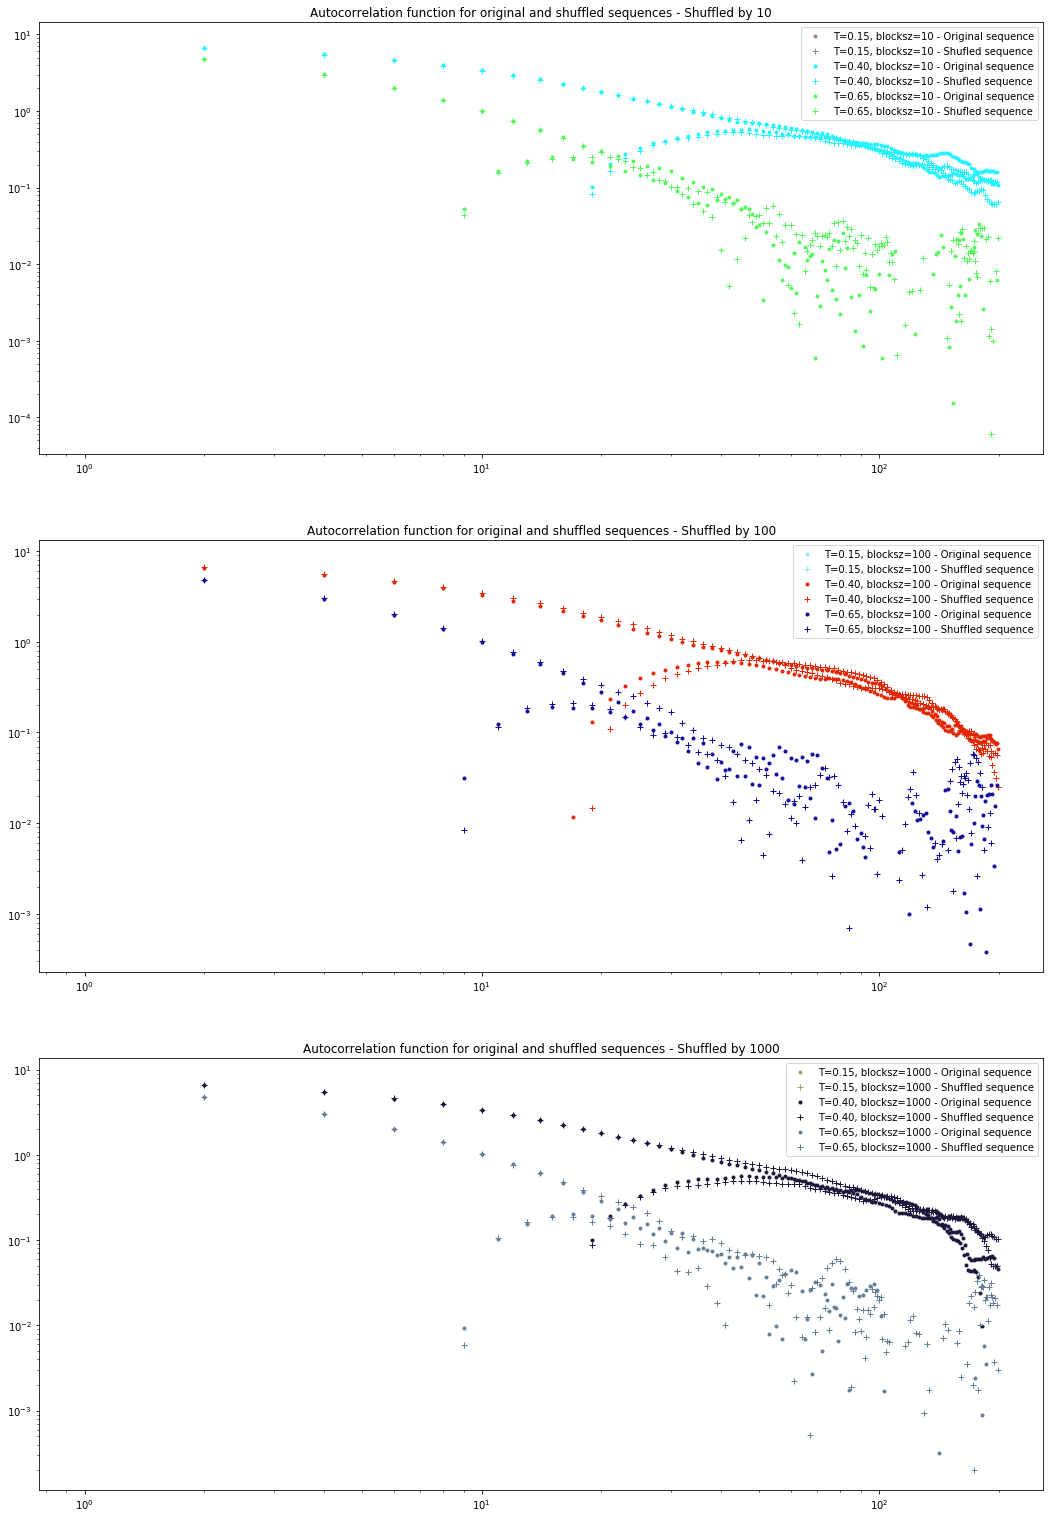

In [14]:
atc_fig = plt.figure(figsize=(18,9*3))
atc_ax = plt.subplot(311)

for params in [(0.15, 10), (0.4, 10), (0.65, 10)]:

    color = np.random.rand(3,)
    
    atc_ax.plot(
        rs.atc_orig[params],
        marker='.',
        ls='none',
        color = color,
        label='T={0:.2f}, blocksz={1:d} - Original sequence'.format(params[0], params[1])
    )

    for test_id, atc_shfl_test in enumerate(rs.atc_shfl[params][:1]):
        atc_ax.plot(
            atc_shfl_test,
            marker='+',
            ls='none',
            color = color,
            label='T={0:.2f}, blocksz={1:d} - Shufled sequence'.format(params[0], params[1])
        )

plt.xscale("log")
plt.yscale("log")
    
plt.title('Autocorrelation function for original and shuffled sequences - Shuffled by 10')
atc_ax.legend()


atc_ax = plt.subplot(312)

for params in [(0.15, 100), (0.4, 100), (0.65, 100)]:

    color = np.random.rand(3,)
    
    atc_ax.plot(
        rs.atc_orig[params],
        marker='.',
        ls='none',
        color = color,
        label='T={0:.2f}, blocksz={1:d} - Original sequence'.format(params[0], params[1])
    )

    for test_id, atc_shfl_test in enumerate(rs.atc_shfl[params][:1]):
        atc_ax.plot(
            atc_shfl_test,
            marker='+',
            ls='none',
            color = color,
            label='T={0:.2f}, blocksz={1:d} - Shuffled sequence'.format(params[0], params[1])
        )

plt.xscale("log")
plt.yscale("log")
    
plt.title('Autocorrelation function for original and shuffled sequences - Shuffled by 100')
atc_ax.legend()


atc_ax = plt.subplot(313)

for params in [(0.15, 1000), (0.4, 1000), (0.65, 1000)]:

    color = np.random.rand(3,)
    
    atc_ax.plot(
        rs.atc_orig[params],
        marker='.',
        ls='none',
        color = color,
        label='T={0:.2f}, blocksz={1:d} - Original sequence'.format(params[0], params[1])
    )

    for test_id, atc_shfl_test in enumerate(rs.atc_shfl[params][:1]):
        atc_ax.plot(
            atc_shfl_test,
            marker='+',
            ls='none',
            color = color,
            label='T={0:.2f}, blocksz={1:d} - Shuffled sequence'.format(params[0], params[1])
        )

plt.xscale("log")
plt.yscale("log")
    
plt.title('Autocorrelation function for original and shuffled sequences - Shuffled by 1000')
atc_ax.legend()

## Accuracy = f(t) plots

In [15]:
import pdb

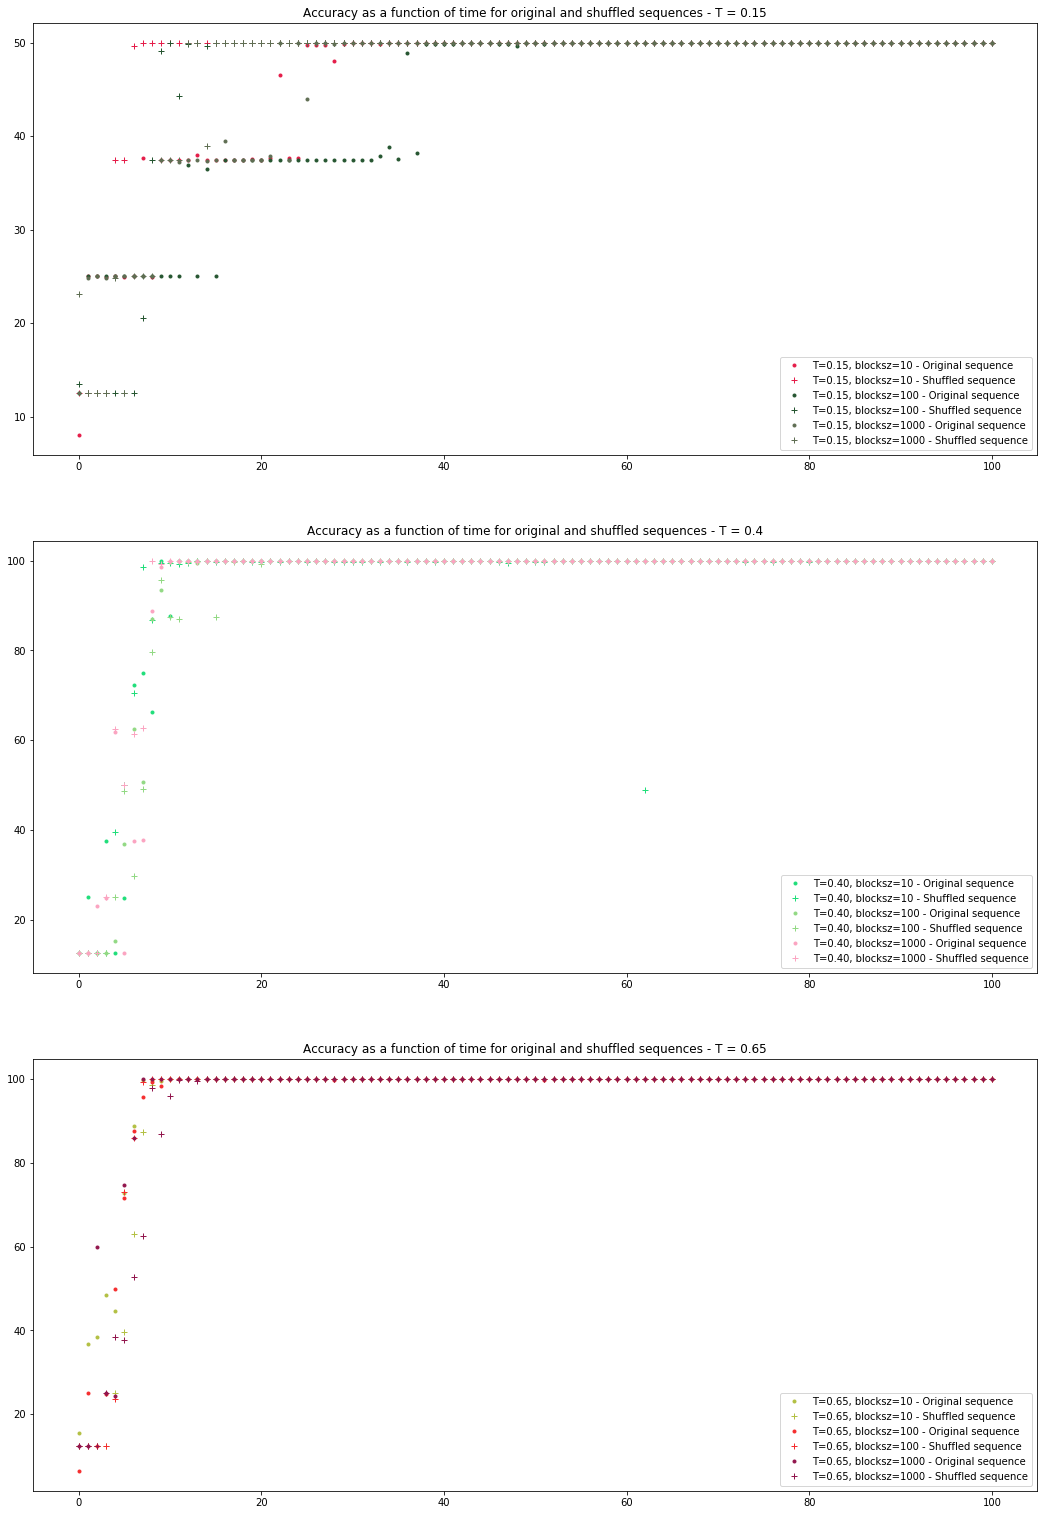

In [16]:
acc_fig = plt.figure(figsize=(18,9*3))
acc_ax = plt.subplot(311)

for params in [(0.15, 10), (0.15, 100), (0.15, 1000)]:
    
    color = np.random.rand(3,)
    
    acc_ax.plot(
        rs.var_acc_orig[params][:,0],
        marker = '.',
        ls = 'none',
        color = color,
        label='T={0:.2f}, blocksz={1:d} - Original sequence'.format(params[0], params[1])
    )

    acc_ax.plot(
        rs.var_acc_shfl[params][:,0],
        marker='+',
        ls = 'none',
        color = color,
        label='T={0:.2f}, blocksz={1:d} - Shuffled sequence'.format(params[0], params[1])
    )
    
plt.title('Accuracy as a function of time for original and shuffled sequences - T = 0.15')
acc_ax.legend()


acc_ax = plt.subplot(312)

for params in [(0.4, 10), (0.4, 100), (0.4, 1000)]:
    
    color = np.random.rand(3,)
    
    acc_ax.plot(
        rs.var_acc_orig[params][:,0],
        marker = '.',
        ls = 'none',
        color = color,
        label='T={0:.2f}, blocksz={1:d} - Original sequence'.format(params[0], params[1])
    )

    acc_ax.plot(
        rs.var_acc_shfl[params][:,0],
        marker='+',
        ls = 'none',
        color = color,
        label='T={0:.2f}, blocksz={1:d} - Shuffled sequence'.format(params[0], params[1])
    )
    
plt.title('Accuracy as a function of time for original and shuffled sequences - T = 0.4')
acc_ax.legend()


acc_ax = plt.subplot(313)

for params in [(0.65, 10), (0.65, 100), (0.65, 1000)]:
    
    color = np.random.rand(3,)
    
    acc_ax.plot(
        rs.var_acc_orig[params][:,0],
        marker = '.',
        ls = 'none',
        color = color,
        label='T={0:.2f}, blocksz={1:d} - Original sequence'.format(params[0], params[1])
    )

    acc_ax.plot(
        rs.var_acc_shfl[params][:,0],
        marker='+',
        ls = 'none',
        color = color,
        label='T={0:.2f}, blocksz={1:d} - Shuffled sequence'.format(params[0], params[1])
    )
    
plt.title('Accuracy as a function of time for original and shuffled sequences - T = 0.65')
acc_ax.legend()

## Class distribution as function of test run

KeyError: 6

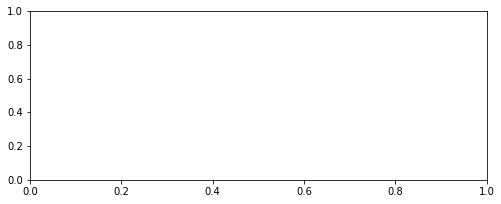

In [17]:
cls_dstr_fig = plt.figure(figsize=(18,18))

params = (0.4, 10)

for test_run_q in range(10): #rs.params['test_nbr'] or whatever
    
    cls_dstr_ax = plt.subplot(5,2,test_run_q+1)
    
    test_run_id = int((test_run_q/10)*rs.params[6])
    cls_dstr_ax.bar(
        range(10)-0.1,
        rs.var_pred_orig[params][test_run_id,0],
        color = 'b'
    )

    cls_dstr_ax.bar(
        range(10)+0.1,
        rs.var_pred_shfl[params][test_run_id,0],
        color = 'r'
    )
    
plt.title('Accuracy as a function of time for original and shuffled sequences - T = 0.15')

## Labels history

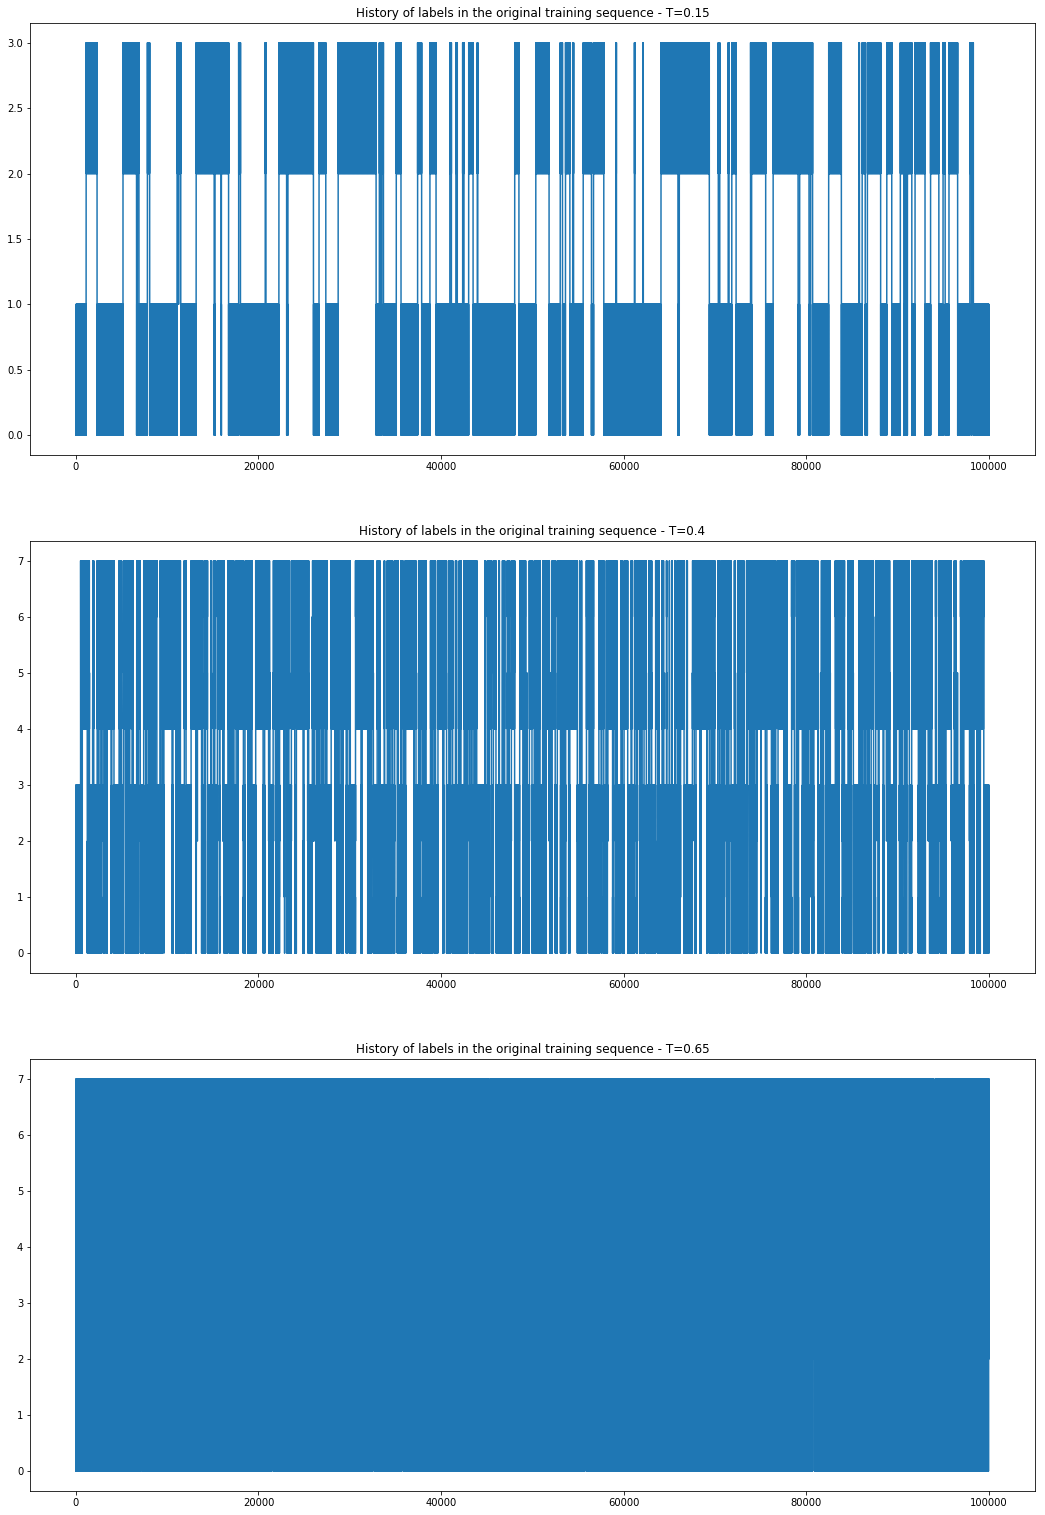

In [18]:
lbls_fig = plt.figure(figsize=(18,9*3))

plt.plot(rs.train_labels_orig[params])

for param_id, params in enumerate([(0.15, 100), (0.4, 100), (0.65, 100)]):
    lbls_ax = plt.subplot(3,1,1+param_id)
    lbls_ax.plot(rs.train_labels_orig[params])
    ttl = 'History of labels in the original training sequence - T='+str(params[0])
    plt.title(ttl)